<img src='MBA.png' width='25%' height='15%' />

# Market Basket Analysis Project

Welcome to the code notebook for Market Basket Analysis (MBA) Project.

MBA shows what combinations of products most frequently occur together in orders. These relationships can be used to increase profitability through cross-selling, recommendations, promotions, or even the placement of items on a menu or in a store.

Let's get started!

## Import Libraries

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from wordcloud import WordCloud

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
    
sns.set_style('white')
%matplotlib inline

In [227]:
## Get the Data

In [228]:
df = pd.read_csv('BreadBasket_DMS.csv')

df['Datetime'] = pd.to_datetime(df['Date']+' '+df['Time'])

df['YearMonth']=df['Datetime'].map(lambda x: 100*x.year + x.month)
df['Hour']=df['Datetime'].dt.hour
df['Day']=df['Datetime'].dt.weekday_name
df['WeekendvsWeekday'] = df['Datetime'].apply(lambda x: 'Weekend' if x.dayofweek//5==1 else 'Weekday')

df = df[["Datetime", "Transaction", "Item","YearMonth","Hour","Day","WeekendvsWeekday"]].set_index("Datetime")


Now let's see a sample data

In [229]:
df.head()

,Transaction,Item,YearMonth,Hour,Day,WeekendvsWeekday
Datetime,,,,,,
2016-10-30 09:58:11,1,Bread,201610,9,Sunday,Weekend
2016-10-30 10:05:34,2,Scandinavian,201610,10,Sunday,Weekend
2016-10-30 10:05:34,2,Scandinavian,201610,10,Sunday,Weekend
2016-10-30 10:07:57,3,Hot chocolate,201610,10,Sunday,Weekend
2016-10-30 10:07:57,3,Jam,201610,10,Sunday,Weekend


# Exploratory Data Analysis

Let's explore the data a bit and get a look at some of the main products.

## WordCloud

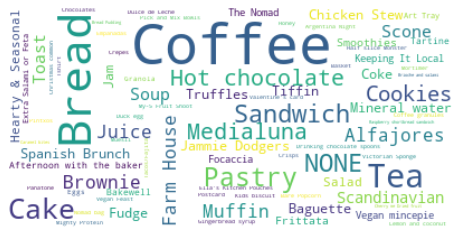

In [230]:
# Create and generate a word cloud image:

items_dict=df.groupby('Item')['Item'].count().sort_values(ascending=False).to_dict()
word_cloud = WordCloud(mode='RGBA', background_color="white", stopwords= None, max_words=20)
wordcloud.generate_from_frequencies(frequencies=items_dict)
plt.figure(figsize=(8,6),facecolor = "white", edgecolor="blue")

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")  
plt.axis("off")
plt.show()

Now let's see more graphics:

In [231]:
#removing all rows where item value is NONE
df=df[df['Item']!='NONE']

Text(0, 0.5, 'Frequency')

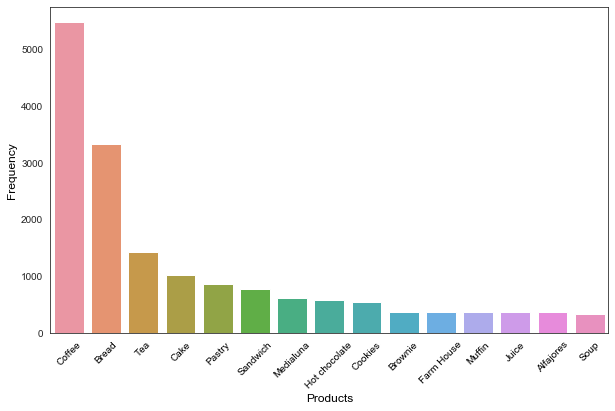

In [232]:
#groupby item
no_of_item_transc= df.groupby(['Item'])['Transaction'].count() 
no_of_item_transc=no_of_item_transc.reset_index()
no_of_item_transc=no_of_item_transc.sort_values(['Transaction'],ascending=False)
top_item_transc=no_of_item_transc.head(15)

#plot graph for highest sold top 15 items
fig,axis=plt.subplots(figsize=(10,6))
axis=sns.barplot(data=top_item_transc,x='Item',y='Transaction')
axis.set_xticklabels(top_item_transc['Item'],rotation=45,color='black')
axis.set_xlabel('Products',color='black',fontsize=12)
axis.set_ylabel('Frequency', fontsize=12,color='black')

Text(0, 0.5, 'Frequency')

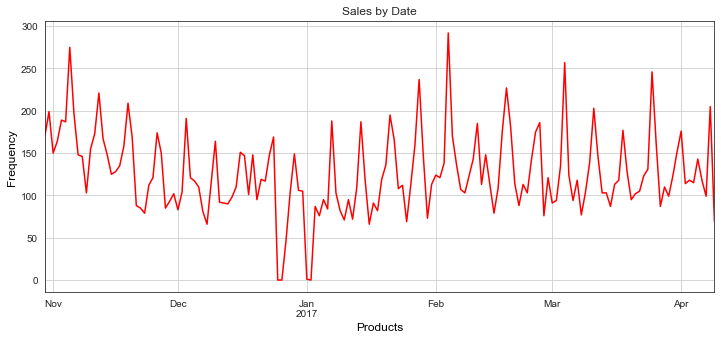

In [252]:
# plot sales by date
axis=df["Item"].resample("D").count().plot(figsize=(12,5), grid=True, title="Sales by Date", color="red")
axis.set_xlabel('Products',color="black",fontsize=12)
axis.set_ylabel('Frequency', fontsize=12,color="black")

Text(0, 0.5, 'Frequency')

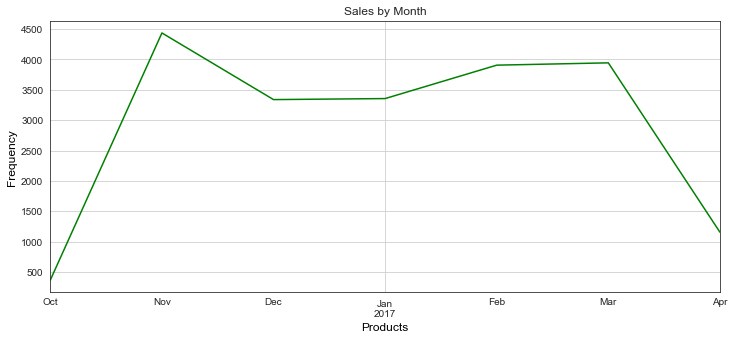

In [253]:
# plot sales by month
axis=df["Item"].resample("M").count().plot(figsize=(12,5), grid=True, title="Sales by Month", color="green")
axis.set_xlabel('Products',color="black",fontsize=12)
axis.set_ylabel('Frequency', fontsize=12,color="black")

Text(0.5, 1.0, 'Frequency by Day')

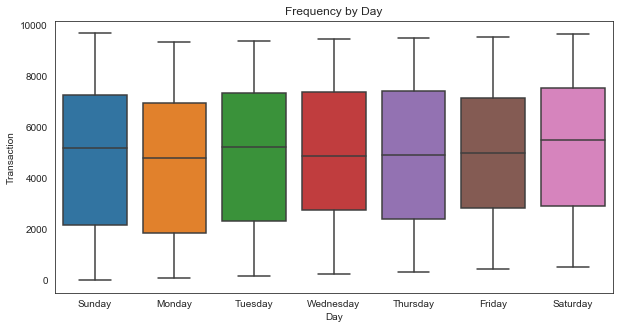

In [261]:
# plot sales by Day
plt.figure(figsize=[10,5])
sns.boxplot(x='Day',y='Transaction',data=df,)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Frequency by Day')

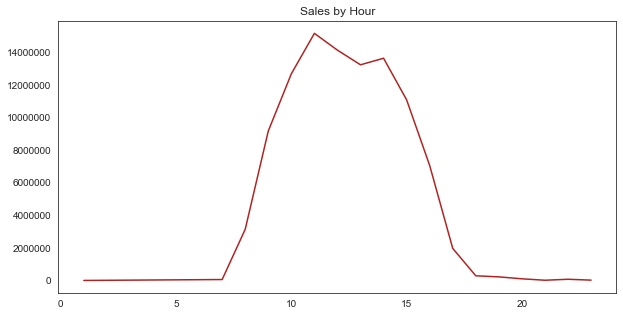

In [267]:
# plot sales by Hour
plt.figure(figsize=[10,5])
plt.ticklabel_format(style='plain', axis='y')
plt.title('Sales by Hour')
plt.plot(df[['Hour','Transaction']].groupby('Hour').sum(), color="firebrick")

In [277]:
Item_by_transaction=df[['Item','Transaction']].groupby('Item',as_index=False).sum().sort_values(by='Transaction',ascending=False)

Item_by_transaction['Transaction %']=Item_by_transaction['Transaction']/Item_by_transaction['Transaction'].sum()

Hour_by_Item=df[['Hour','Item','Transaction']].groupby(['Hour','Item'],as_index=False).sum()

Top_items=list(Item_by_transaction['Item'].head(10))


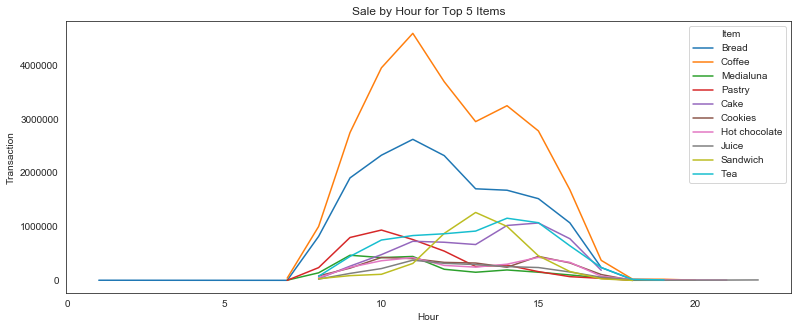

In [279]:

plt.figure(figsize=[13,5])
plt.ticklabel_format(style='plain', axis='y')
plt.title('Sale by Hour for Top 5 Items')
sns.lineplot(x='Hour',y='Transaction',data=Hour_by_Item[Hour_by_Item['Item'].isin(Top_items)],hue='Item')

Okay! Now that we have a general idea of what the data looks like, let's move on to performing a Market Basket Analysis through Apriori Algorithm.

# Analysis

### <font color='darkblue'>*Apriori Algorithm Implementation*</font>

*It is an algorithm for frequent item set mining and association rule learning over transactional databases. It proceeds by identifying the frequent individual items in the database and extending them to larger and larger item sets as long as those item sets appear sufficiently often in the database.* 

*The frequent item sets determined by Apriori can be used to determine association rules which highlight general trends in the database: this has applications in domains such as market basket analysis.*

In [358]:
#preparing the data for applying apriori
# filling all the null vaues with zero and later unstacking them to fed to apriori to find CONFIDENCE, SUPPORT and LIFT
apr_data=df.copy()

grp_apr_data = apr_data.groupby(['Transaction', 'Item'])['Item'].count().unstack().reset_index().fillna(0).set_index('Transaction')
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
hot_encoded_df = grp_apr_data.applymap(encode_units)

# applying support with min value of 3%
frequent_itemsets =apriori(hot_encoded_df, min_support=0.03,use_colnames=True)
print('Items with min 3% support are:','\n', frequent_itemsets)

Items with min 3% support are: 
      support             itemsets
0   0.036344          (Alfajores)
1   0.327205              (Bread)
2   0.040042            (Brownie)
3   0.103856               (Cake)
4   0.478394             (Coffee)
5   0.054411            (Cookies)
6   0.039197         (Farm House)
7   0.058320      (Hot chocolate)
8   0.038563              (Juice)
9   0.061807          (Medialuna)
10  0.038457             (Muffin)
11  0.086107             (Pastry)
12  0.071844           (Sandwich)
13  0.034548              (Scone)
14  0.034443               (Soup)
15  0.142631                (Tea)
16  0.033597              (Toast)
17  0.090016      (Coffee, Bread)
18  0.054728       (Coffee, Cake)
19  0.035182  (Coffee, Medialuna)
20  0.047544     (Coffee, Pastry)
21  0.038246   (Coffee, Sandwich)
22  0.049868        (Coffee, Tea)


### <font color='darkblue'>*Association Rules Mining*</font>

* *Support: This is the percentage of orders that contains the item set.*
* *Confidence: Given two items, A and B, confidence measures the percentage of times that item B is purchased, given that item A was purchased.*
* *Lift: Given two items, A and B, lift indicates whether there is a relationship between A and B, or whether the two items are occuring together in the same orders simply by chance (ie: at random).*

In [359]:
# applying lift to items which have min value of support of 3% 
lift_items = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
lift_items


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Coffee),(Cake),0.478394,0.103856,0.054728,0.114399,1.101515,0.005044,1.011905
1,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
2,(Coffee),(Medialuna),0.478394,0.061807,0.035182,0.073542,1.189878,0.005614,1.012667
3,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
4,(Coffee),(Pastry),0.478394,0.086107,0.047544,0.099382,1.154168,0.006351,1.014740
5,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682
6,(Coffee),(Sandwich),0.478394,0.071844,0.038246,0.079947,1.112792,0.003877,1.008807
7,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384


In [360]:
print('most sold pair of items are:','\n',lift_items[['antecedents','consequents','consequent support','confidence','lift']])

most sold pair of items are: 
    antecedents  consequents  consequent support  confidence      lift
0     (Coffee)       (Cake)            0.103856    0.114399  1.101515
1       (Cake)     (Coffee)            0.478394    0.526958  1.101515
2     (Coffee)  (Medialuna)            0.061807    0.073542  1.189878
3  (Medialuna)     (Coffee)            0.478394    0.569231  1.189878
4     (Coffee)     (Pastry)            0.086107    0.099382  1.154168
5     (Pastry)     (Coffee)            0.478394    0.552147  1.154168
6     (Coffee)   (Sandwich)            0.071844    0.079947  1.112792
7   (Sandwich)     (Coffee)            0.478394    0.532353  1.112792


#### Data Visualization with NetworkX library for Association Rules

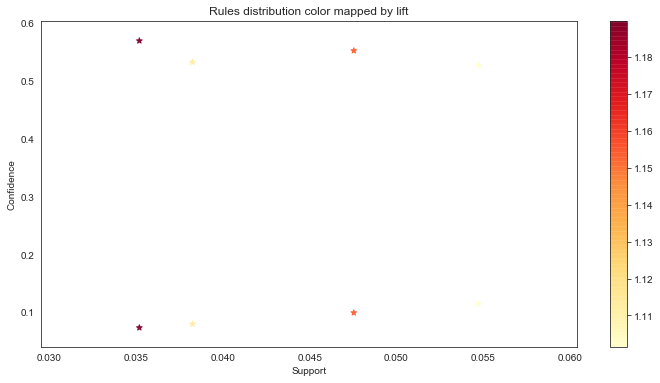

In [361]:
   
plt.figure(figsize=(12, 6))
plt.scatter(lift_items['support'], lift_items['confidence'], c=lift_items['lift'], alpha=0.9, marker="*" ,  cmap='YlOrRd')
plt.title('Rules distribution color mapped by lift');
plt.xlabel('Support')
plt.ylabel('Confidence') 
plt.colorbar()

In [362]:
def draw_graph(rules, rules_to_show):
  import networkx as nx  
  G1 = nx.DiGraph()
   
  color_map=[]
  N = 50
  colors = np.random.rand(N)    
  strs=['R0', 'R1', 'R2', 'R3','R4','R5','R6','R7']   
   
   
  for i in range (rules_to_show):      
    G1.add_nodes_from(["R"+str(i)])
    
     
    for a in rules.iloc[i]['antecedents']:
                
        G1.add_nodes_from([a])
        
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
       
    for c in rules.iloc[i]['consequents']:
             
            G1.add_nodes_from([c])
            
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
  for node in G1:
       found_a_string = False
       for item in strs: 
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('yellow')
       else:
            color_map.append('green')       
 
 
  plt.figure(figsize=(12,6))
  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]
 
  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
  for p in pos:  # raise text positions
           pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos)

  plt.show()



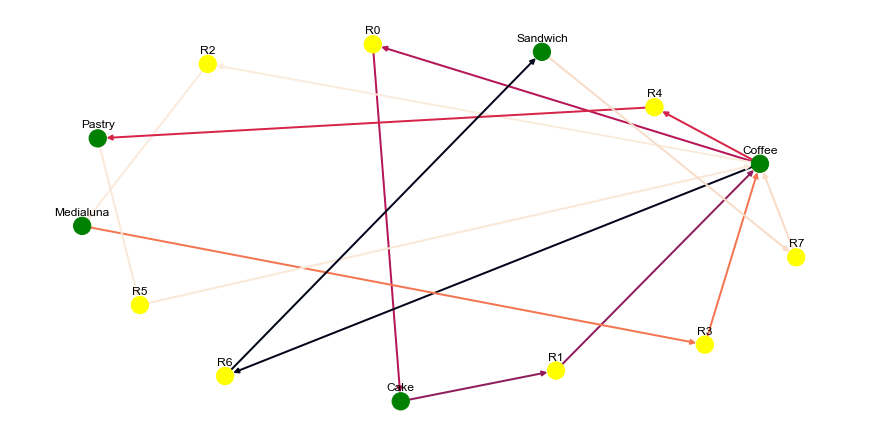

In [363]:
draw_graph(lift_items, 8)

In [ ]:
# Findings

* Coffee is frequently purchased and is present in the more requested combos.
* The purchase of Coffe leads to the purchase of Cake, Medialuna, Pastry, or Sandwich.
* Above combinations constitutes an opportunity to promote combo offers.